In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available (makes training faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set a seed so results are the same every time we run this
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


Here we download the Fashion MNIST dataset.

    Transform: We convert the images (which are grids of numbers) into PyTorch "Tensors" and normalize them (make the numbers smaller and centered around 0) to help the model learn better.

    Batch Size: We look at 64 images at a time.

In [2]:
# 1. Define transformations (Convert to Tensor & Normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Download Training and Test Data
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 3. Create Data Loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define class names for readability
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Training samples: 60000
Test samples: 10000


Plots a few images from the training set so we can see the clothes and their labels.

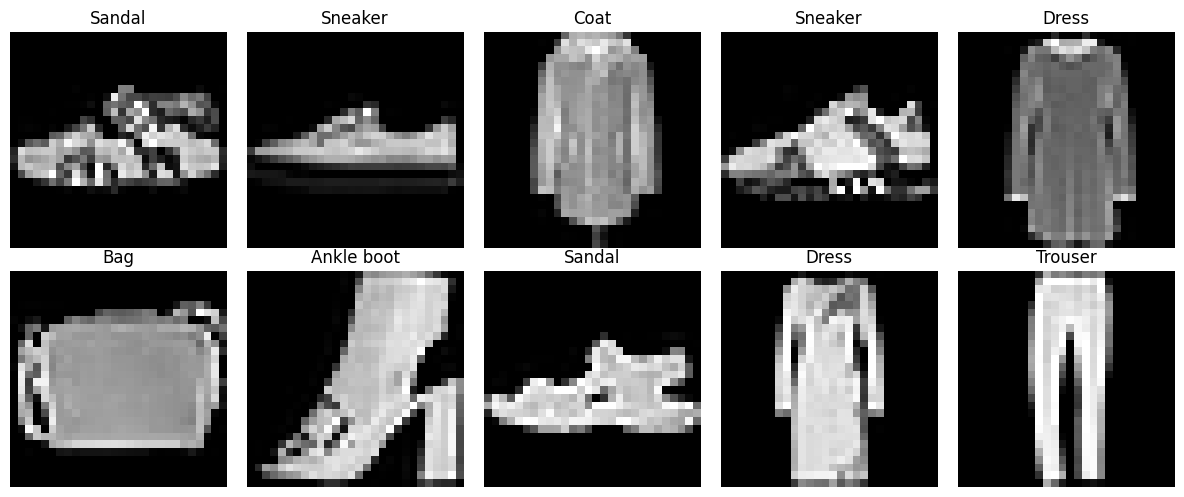

In [3]:
# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot first 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # Un-normalize image for display
    img = images[i] / 2 + 0.5  
    npimg = img.numpy()
    
    # Display
    ax.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    ax.set_title(class_names[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

This is the brain of our project. We build a Feedforward Neural Network.

    Input: 784 neurons (28x28 pixels flattened).

    Hidden Layers: We use 3 hidden layers as requested.

    Activation: We use ReLU (Rectified Linear Unit), which just means "if the number is negative, make it zero." This simple rule helps the network learn complex shapes.

    Output: 10 neurons (one for each type of clothing).

In [5]:
class DeepFashionNet(nn.Module):
    def __init__(self):
        super(DeepFashionNet, self).__init__()
        
        # Flatten: Turns 28x28 image into a vector of 784 numbers
        self.flatten = nn.Flatten()
        
        # We build a stack of layers
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(784, 256),
            nn.ReLU(),
            
            # Layer 2
            nn.Linear(256, 128),
            nn.ReLU(),
            
            # Layer 3
            nn.Linear(128, 64),
            nn.ReLU(),
            
            # Output Layer (10 classes)
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits

# Initialize model and move to GPU if available
model = DeepFashionNet().to(device)
print(model)

DeepFashionNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


Loss Function (CrossEntropy): Calculates how "wrong" the model's guess was.

Optimizer (Adam): Adjusts the model's weights based on the error to improve it for the next time. We use a learning rate of 0.001.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We run this loop for a number of "epochs" (times we go through the whole dataset).

    Forward Pass: The model makes a guess.

    Calculate Loss: We check how wrong the guess is.

    Backward Pass: We calculate gradients (direction to change weights).

    Optimizer Step: We update the weights to reduce error.

In [7]:
epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

print("Starting Training...")

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # --- Testing Phase ---
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad(): # Don't track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Acc: {test_acc:.2f}%")

print("Training Finished!")

Starting Training...
Epoch [1/10] | Train Loss: 0.5221 | Train Acc: 81.07% | Test Acc: 85.14%
Epoch [2/10] | Train Loss: 0.3711 | Train Acc: 86.53% | Test Acc: 85.41%
Epoch [3/10] | Train Loss: 0.3346 | Train Acc: 87.58% | Test Acc: 86.59%
Epoch [4/10] | Train Loss: 0.3136 | Train Acc: 88.41% | Test Acc: 87.51%
Epoch [5/10] | Train Loss: 0.2924 | Train Acc: 89.12% | Test Acc: 86.93%
Epoch [6/10] | Train Loss: 0.2766 | Train Acc: 89.80% | Test Acc: 88.05%
Epoch [7/10] | Train Loss: 0.2619 | Train Acc: 90.12% | Test Acc: 87.85%
Epoch [8/10] | Train Loss: 0.2496 | Train Acc: 90.53% | Test Acc: 87.13%
Epoch [9/10] | Train Loss: 0.2374 | Train Acc: 91.06% | Test Acc: 87.98%
Epoch [10/10] | Train Loss: 0.2262 | Train Acc: 91.48% | Test Acc: 88.26%
Training Finished!


We plot the Accuracy and Loss over time.

    Loss: Should go DOWN.

    Accuracy: Should go UP.

    If Training Accuracy keeps going up but Test Accuracy stops or goes down, we are Overfitting (memorizing instead of learning).

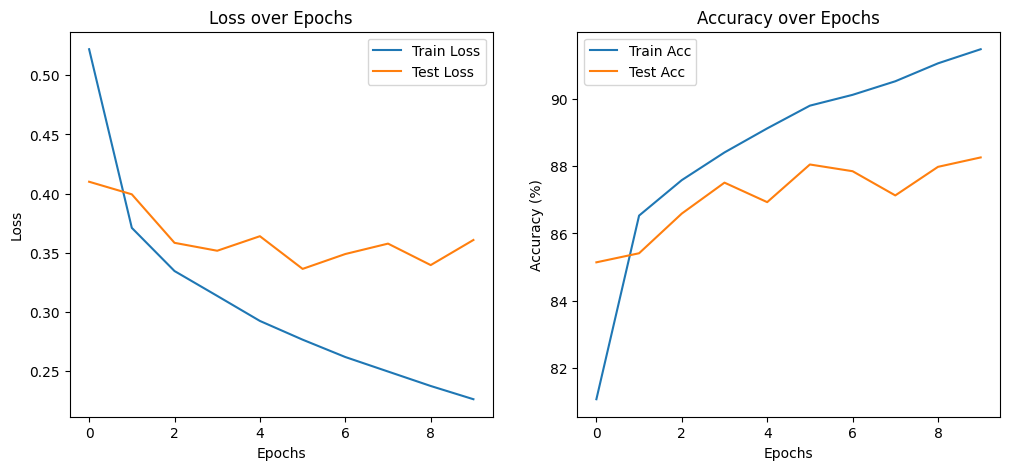

In [8]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Advanced Task 1 - Depth & Width

Experiment with different depths (number of layers) and widths (number of neurons). Analysis:

    Shallow networks learn fast but might miss complex patterns.

    Deep networks (like our 3-layer one) learn complex patterns but are harder to train and can overfit.

    Here, we define a helper function to create models with varying hidden layers easily.

--- Starting Depth Experiments ---

Training Shallow (1 Layer)...
Epoch 1: Loss 0.5006
Epoch 2: Loss 0.3807
Epoch 3: Loss 0.3436
Epoch 4: Loss 0.3200
Epoch 5: Loss 0.3017

Training Medium (3 Layers)...
Epoch 1: Loss 0.5191
Epoch 2: Loss 0.3800
Epoch 3: Loss 0.3388
Epoch 4: Loss 0.3148
Epoch 5: Loss 0.2955

Training Deep (5 Layers)...
Epoch 1: Loss 0.5683
Epoch 2: Loss 0.3945
Epoch 3: Loss 0.3531
Epoch 4: Loss 0.3231
Epoch 5: Loss 0.3043


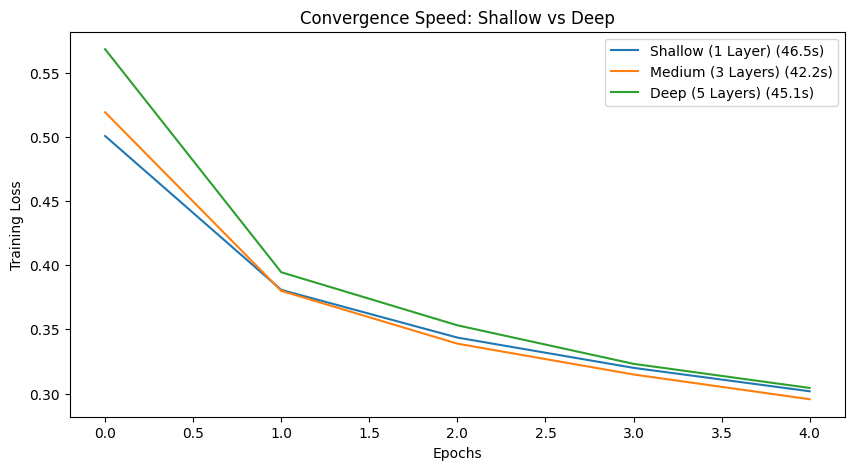

In [12]:
import time

# 1. Dynamic Model Class
class DynamicNet(nn.Module):
    def __init__(self, layer_sizes):
        super(DynamicNet, self).__init__()
        self.flatten = nn.Flatten()
        layers = []
        input_dim = 784 # 28x28
        
        # Build layers dynamically from list
        for hidden_dim in layer_sizes:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU()) # Default to ReLU
            input_dim = hidden_dim
            
        layers.append(nn.Linear(input_dim, 10)) # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(self.flatten(x))

# 2. Define Configurations
configs = {
    "Shallow (1 Layer)": [128],
    "Medium (3 Layers)": [256, 128, 64],
    "Deep (5 Layers)": [512, 256, 128, 64, 32]
}

results = {}

# 3. Training Loop for Experiments
print("--- Starting Depth Experiments ---")

for name, layers in configs.items():
    print(f"\nTraining {name}...")
    model = DynamicNet(layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Track history
    loss_history = []
    start_time = time.time()
    
    # Train for 5 epochs just to see convergence speed
    for epoch in range(5):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")
        
    duration = time.time() - start_time
    results[name] = {'loss': loss_history, 'time': duration}

# 4. Plot Comparison
plt.figure(figsize=(10, 5))
for name, data in results.items():
    plt.plot(data['loss'], label=f"{name} ({data['time']:.1f}s)")
    
plt.title("Convergence Speed: Shallow vs Deep")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

# Advanced Task 2 - Activation Functions

Compare ReLU vs Sigmoid.

    ReLU: Works great for deep networks. It solves the "vanishing gradient" problem.

    Sigmoid: Smashes numbers between 0 and 1. For deep networks, this makes gradients tiny, and the network stops learning (learns very slowly).

--- Starting Activation Experiments ---

Training with Sigmoid...
Epoch 1 Test Acc: 82.01%
Epoch 2 Test Acc: 85.29%
Epoch 3 Test Acc: 85.13%
Epoch 4 Test Acc: 86.83%
Epoch 5 Test Acc: 87.13%

Training with Tanh...
Epoch 1 Test Acc: 83.41%
Epoch 2 Test Acc: 84.84%
Epoch 3 Test Acc: 85.15%
Epoch 4 Test Acc: 86.18%
Epoch 5 Test Acc: 86.85%

Training with ReLU...
Epoch 1 Test Acc: 82.94%
Epoch 2 Test Acc: 85.51%
Epoch 3 Test Acc: 86.93%
Epoch 4 Test Acc: 87.18%
Epoch 5 Test Acc: 86.43%

Training with LeakyReLU...
Epoch 1 Test Acc: 84.69%
Epoch 2 Test Acc: 85.88%
Epoch 3 Test Acc: 85.84%
Epoch 4 Test Acc: 87.41%
Epoch 5 Test Acc: 87.04%


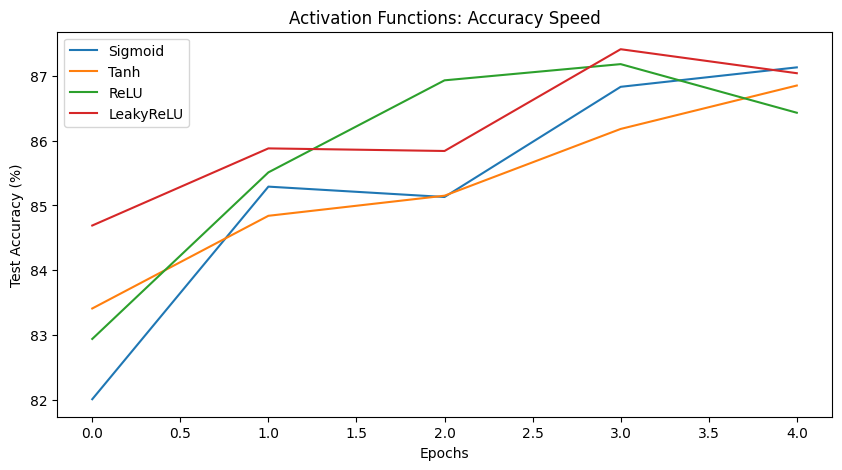

In [17]:
# 1. Model with Swappable Activation
class ActivationNet(nn.Module):
    def __init__(self, activation_func):
        super(ActivationNet, self).__init__()
        self.flatten = nn.Flatten()
        # Using a deep network to highlight the differences
        self.network = nn.Sequential(
            nn.Linear(784, 256), activation_func,
            nn.Linear(256, 128), activation_func,
            nn.Linear(128, 64), activation_func,
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(self.flatten(x))

# 2. Define Activations
activations = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(0.01)
}

act_results = {}

# 3. Train Loop
print("--- Starting Activation Experiments ---")

for name, act_func in activations.items():
    print(f"\nTraining with {name}...")
    model = ActivationNet(act_func).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    acc_history = []
    
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Check accuracy at end of epoch
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        acc_history.append(acc)
        print(f"Epoch {epoch+1} Test Acc: {acc:.2f}%")
        
    act_results[name] = acc_history

# 4. Plot Results
plt.figure(figsize=(10, 5))
for name, accs in act_results.items():
    plt.plot(accs, label=name)

plt.title("Activation Functions: Accuracy Speed")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.show()

# Advanced Task 3 - Visualize Hidden Layers

Briefly training model for visualization...
Visualizing activations for class: Ankle boot


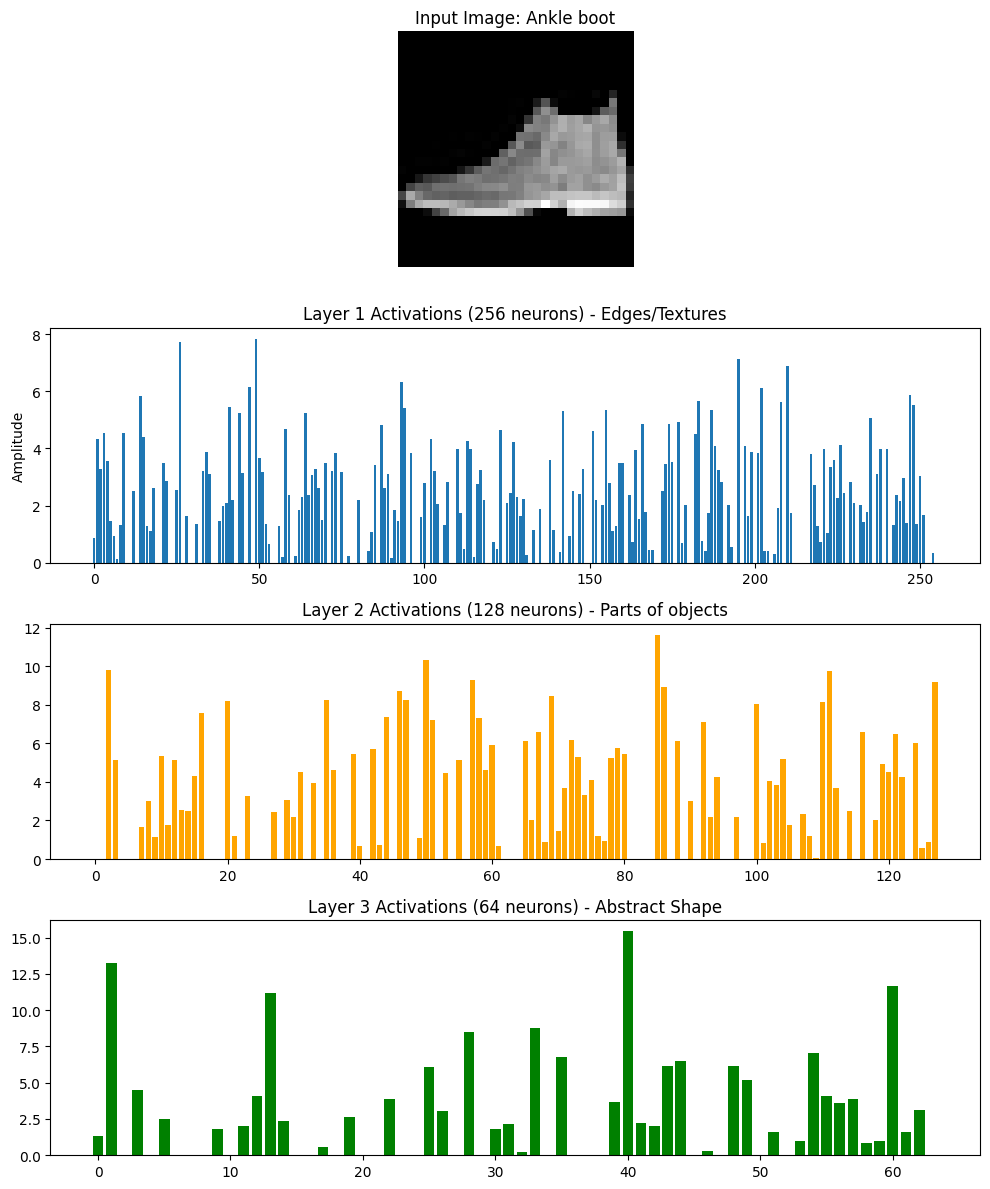

In [16]:
# 1. Pick a sample image and Setup
# Re-create standard model structure matching the trained weights logic
model = DynamicNet([256, 128, 64]).to(device) 

# Fast re-train (just for 50 batches) so we aren't visualizing random noise
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Briefly training model for visualization...")
for i, (imgs, lbls) in enumerate(train_loader):
    if i > 50: break 
    optimizer.zero_grad()
    loss = criterion(model(imgs.to(device)), lbls.to(device))
    loss.backward()
    optimizer.step()

# Get one test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
sample_img = images[0].to(device) # Shape: [1, 28, 28]
label = class_names[labels[0]]

print(f"Visualizing activations for class: {label}")

# 2. Pass data through layers manually
# Flatten input: [1, 28, 28] -> [1, 784]
flat_input = model.flatten(sample_img)

# Layer 1
z1 = model.network[0](flat_input) # Linear
a1 = model.network[1](z1)         # ReLU

# Layer 2
z2 = model.network[2](a1) # Linear
a2 = model.network[3](z2) # ReLU

# Layer 3
z3 = model.network[4](a2) # Linear
a3 = model.network[5](z3) # ReLU

# 3. Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Original Image
axs[0].imshow(sample_img.cpu().squeeze(), cmap='gray')
axs[0].set_title(f"Input Image: {label}")
axs[0].axis('off')

# Layer 1 Activations
# FIX: Added .flatten() to convert [[x,x,x]] to [x,x,x]
axs[1].bar(range(len(a1.detach().cpu().numpy().flatten())), a1.detach().cpu().numpy().flatten())
axs[1].set_title("Layer 1 Activations (256 neurons) - Edges/Textures")
axs[1].set_ylabel("Amplitude")

# Layer 2 Activations
# FIX: Added .flatten()
axs[2].bar(range(len(a2.detach().cpu().numpy().flatten())), a2.detach().cpu().numpy().flatten(), color='orange')
axs[2].set_title("Layer 2 Activations (128 neurons) - Parts of objects")

# Layer 3 Activations
# FIX: Added .flatten()
axs[3].bar(range(len(a3.detach().cpu().numpy().flatten())), a3.detach().cpu().numpy().flatten(), color='green')
axs[3].set_title("Layer 3 Activations (64 neurons) - Abstract Shape")

plt.tight_layout()
plt.show()